
=== EP6 ===
Votes included: 1253
Graph: 911 nodes, 403405 edges


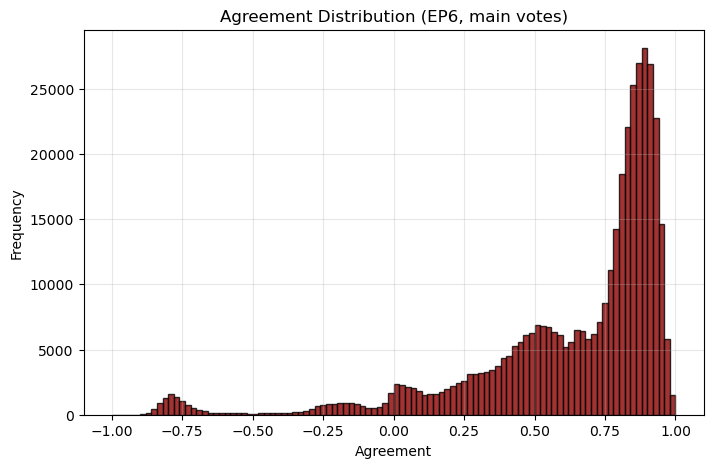

Plotting per-party agreement distributions…


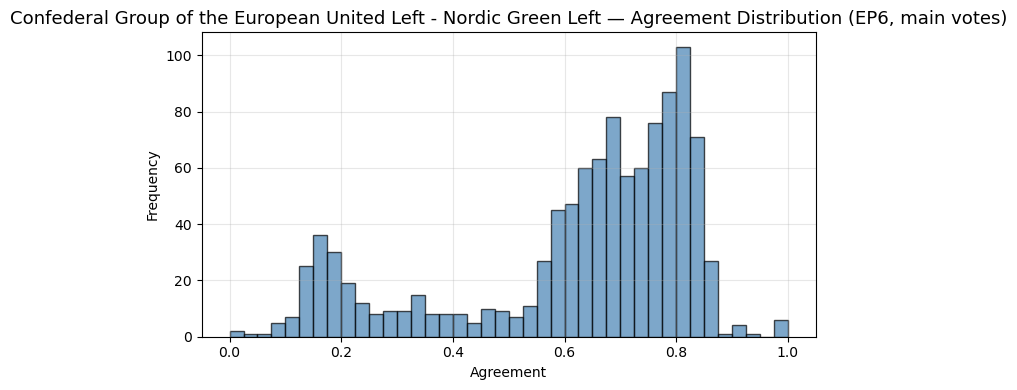

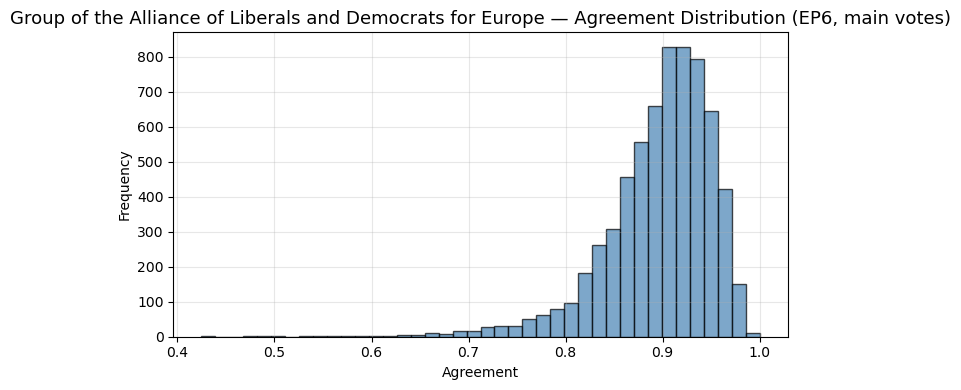

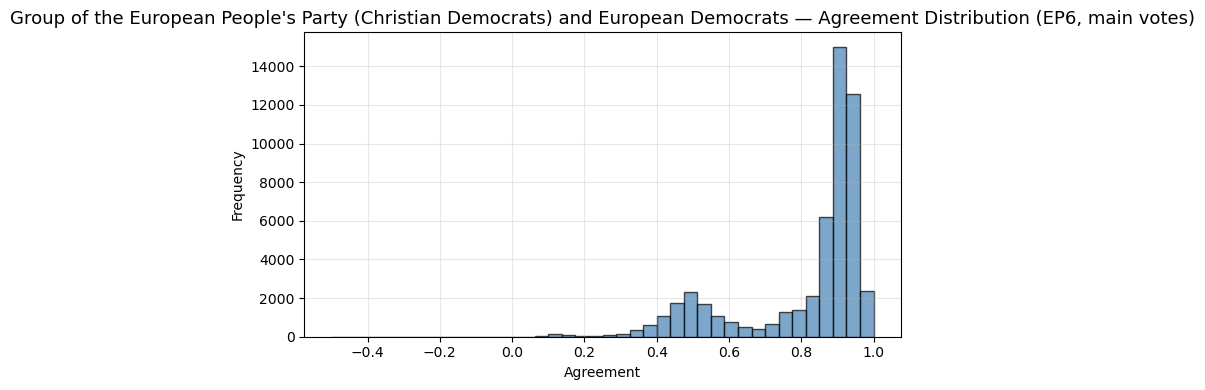

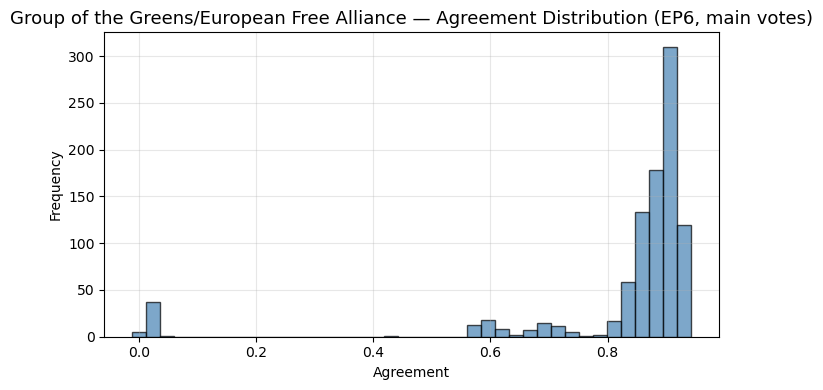

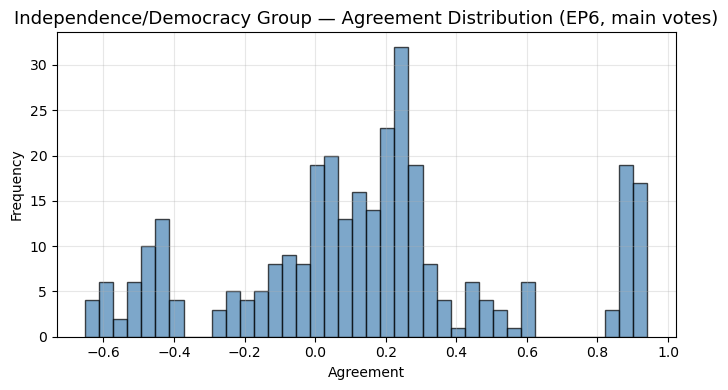

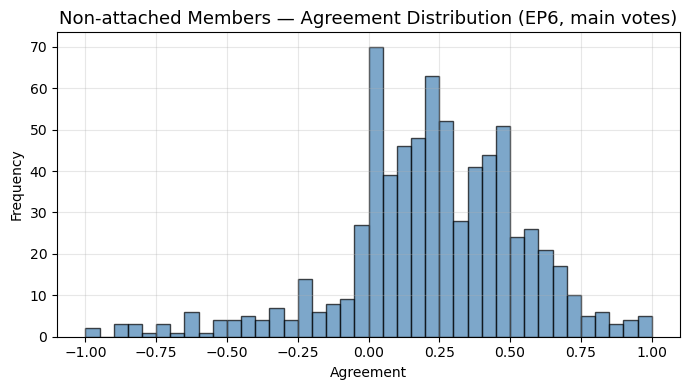

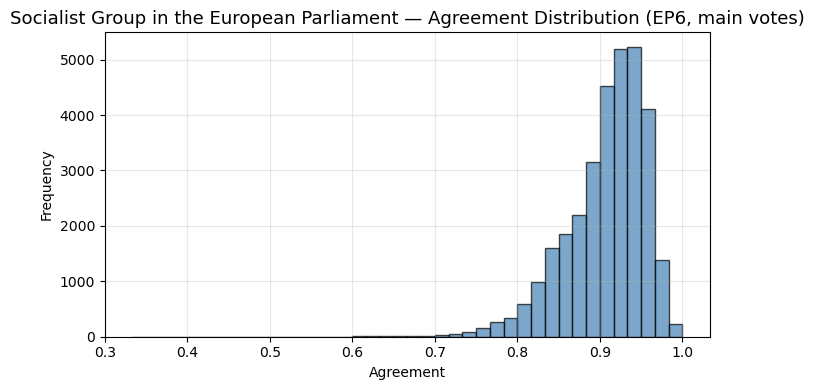

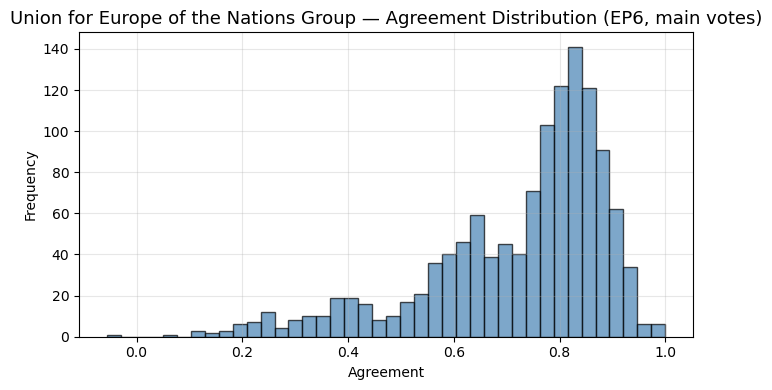


=== EP7 ===
Votes included: 1664
Graph: 844 nodes, 351046 edges


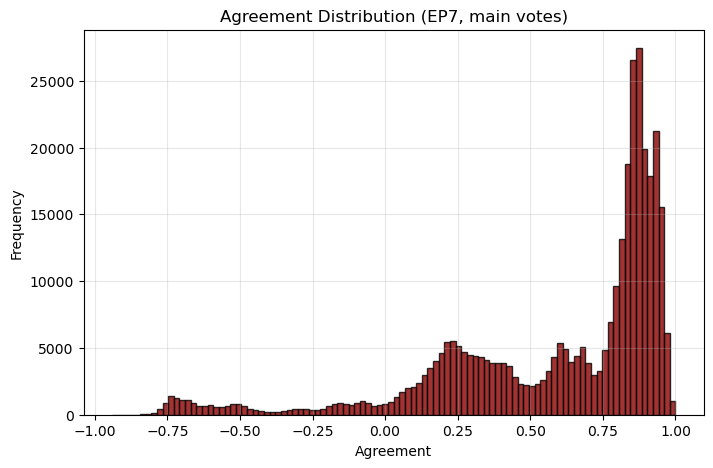

Plotting per-party agreement distributions…


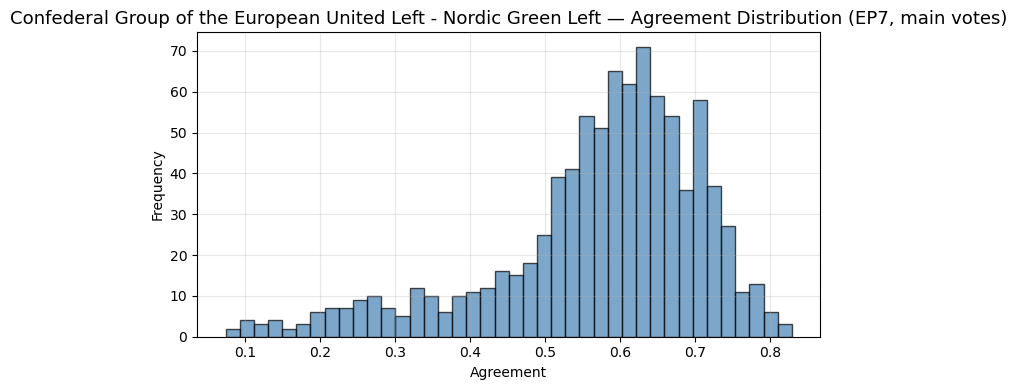

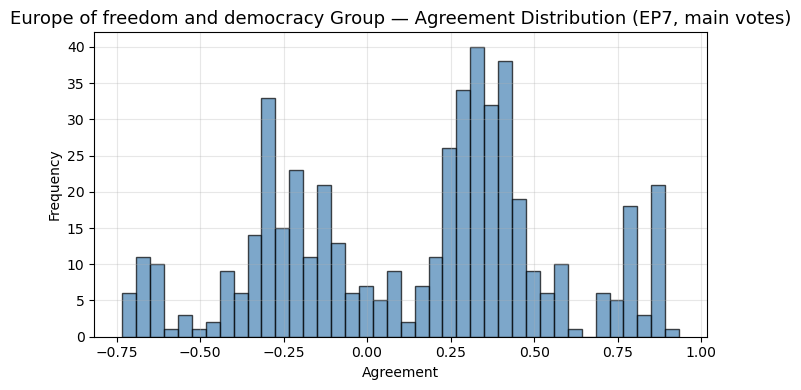

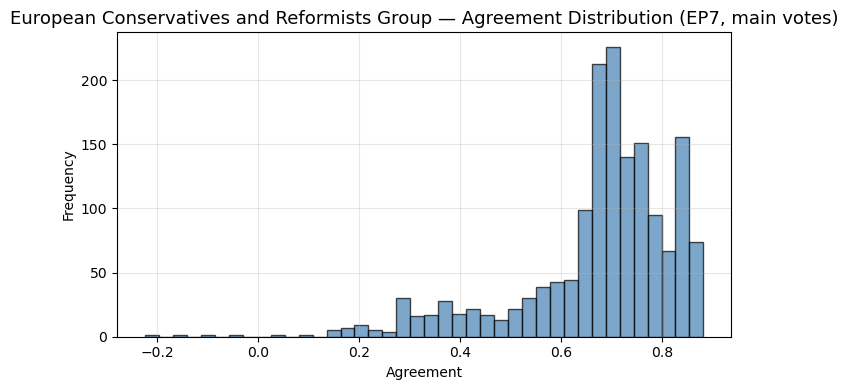

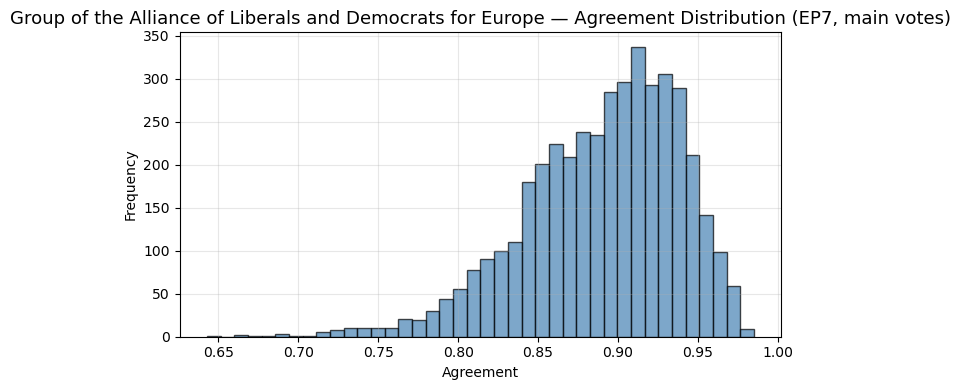

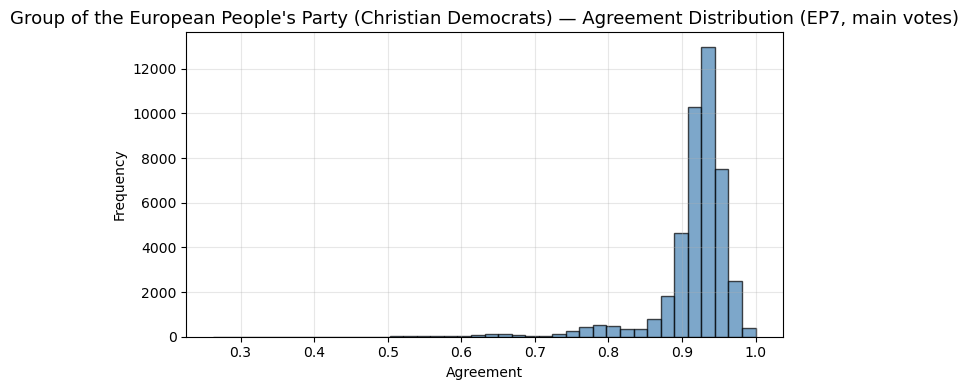

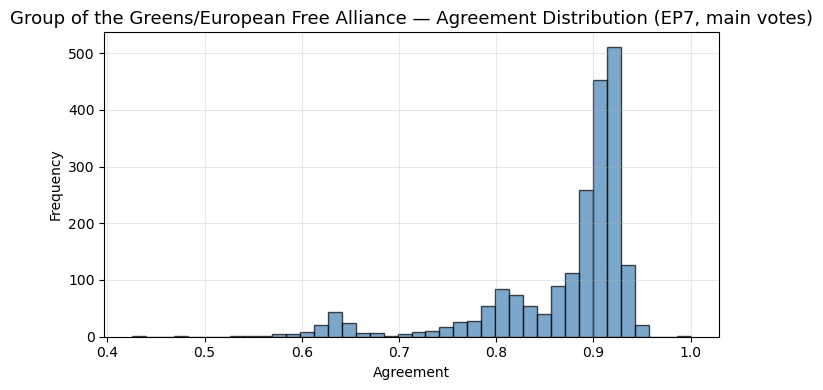

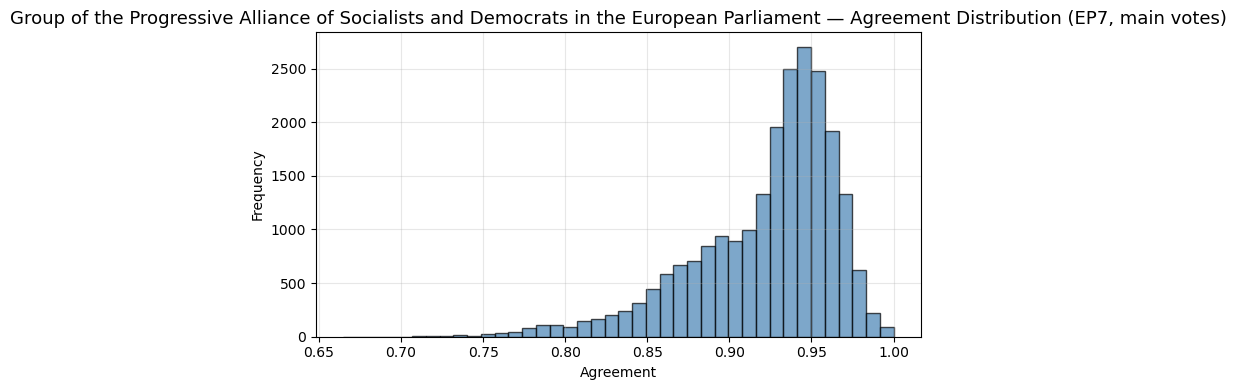

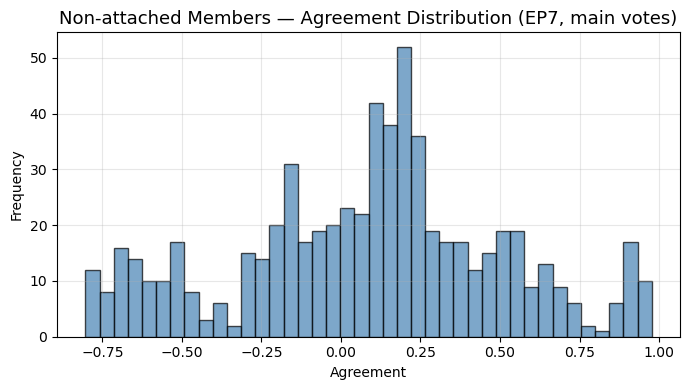


=== EP8 ===
Votes included: 2072
Graph: 833 nodes, 342645 edges


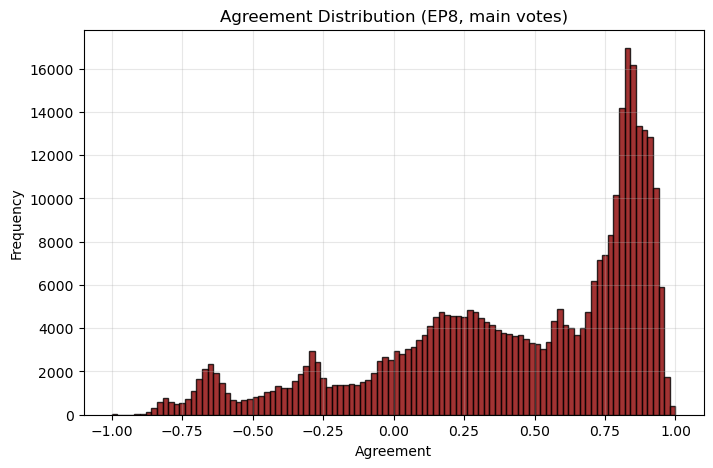

Plotting per-party agreement distributions…


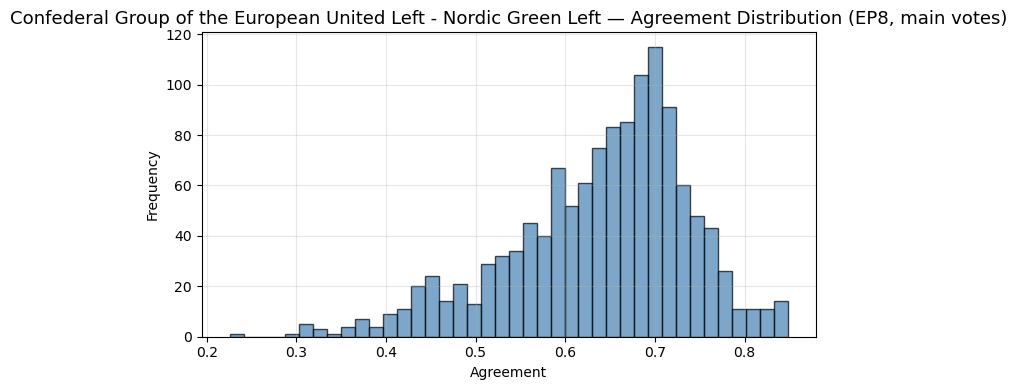

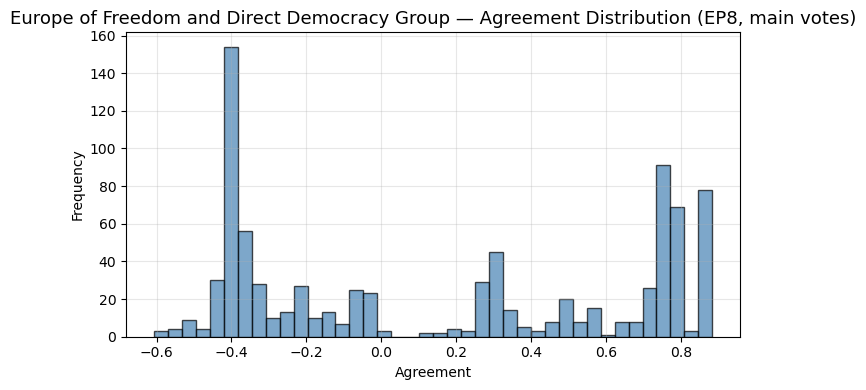

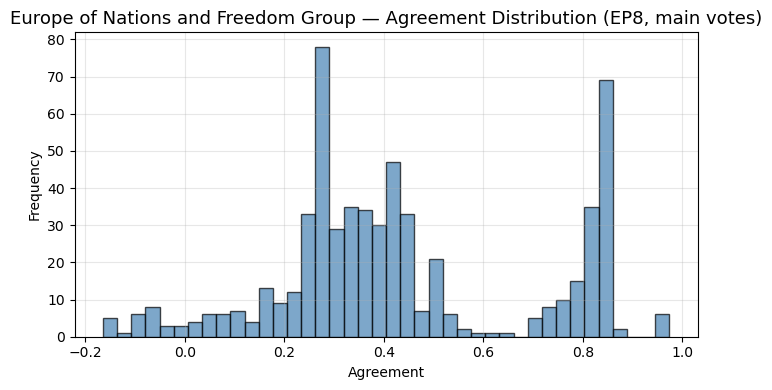

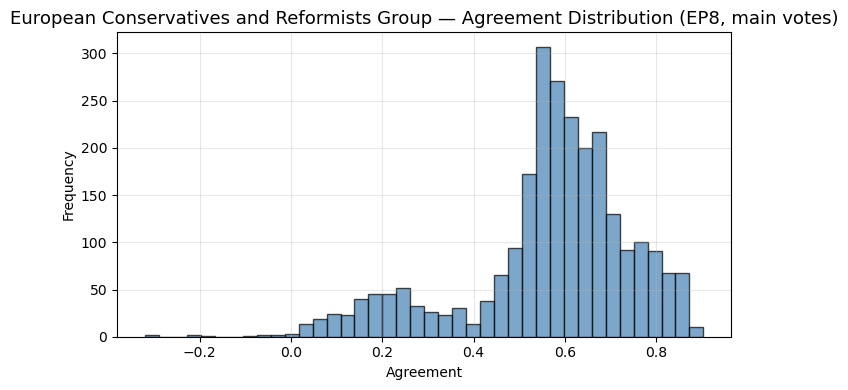

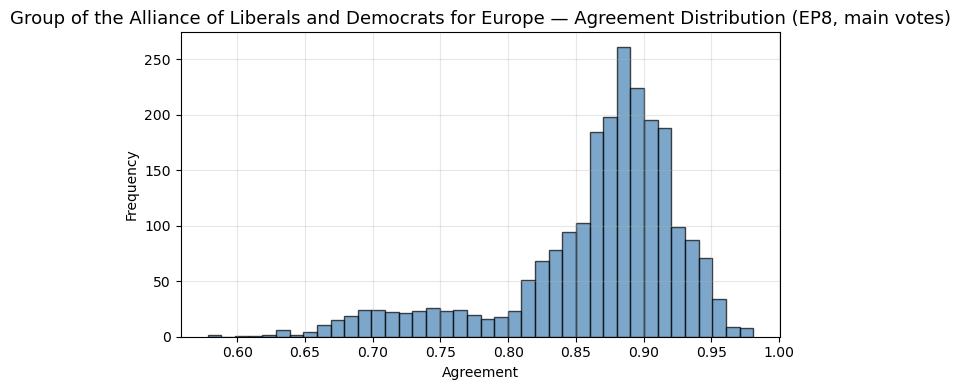

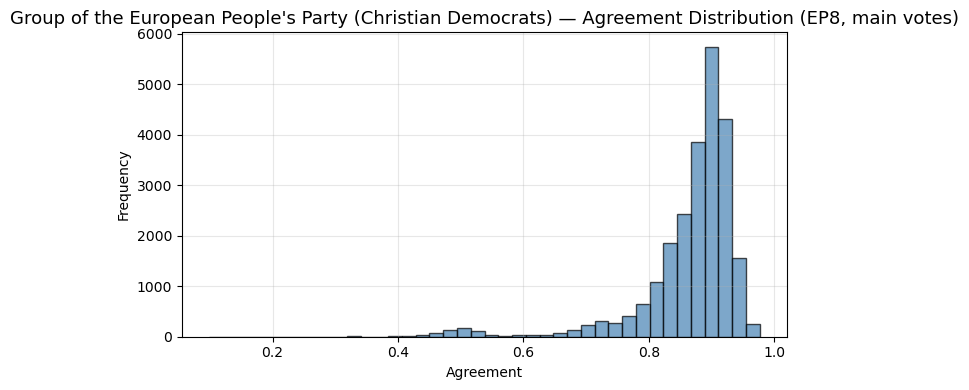

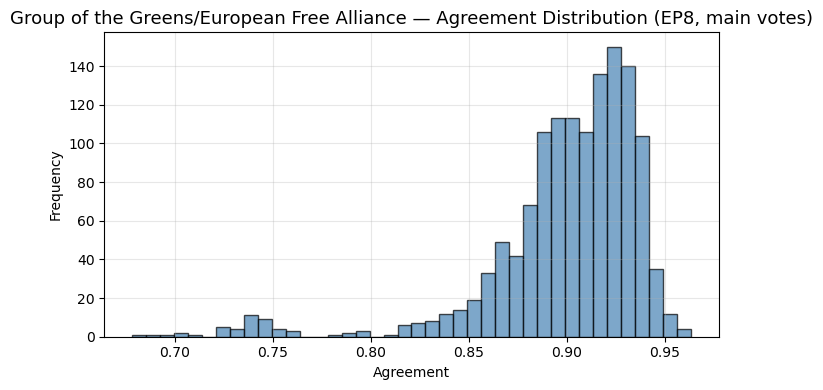

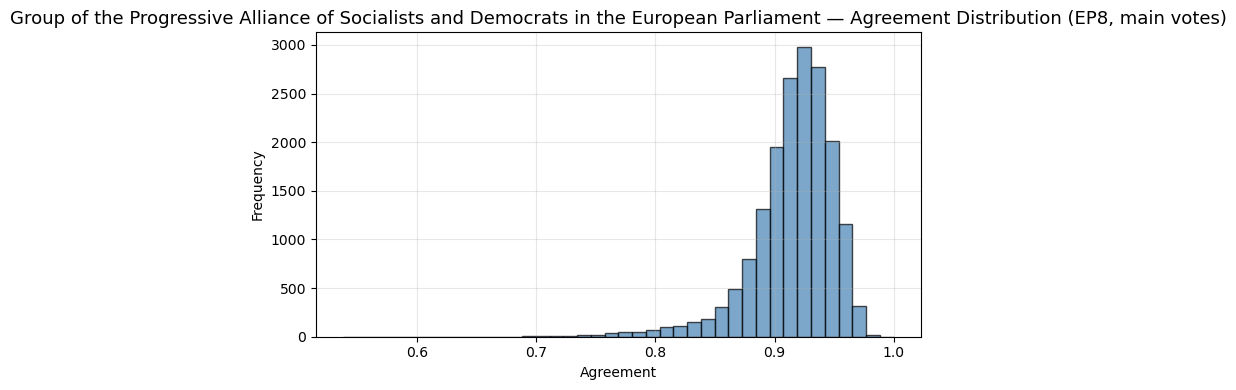

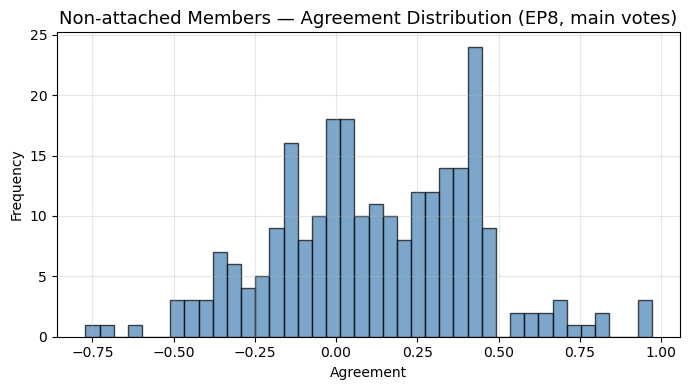

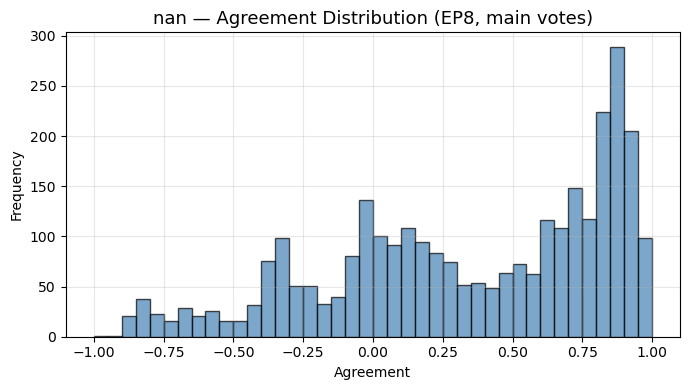


=== EP9 ===
Votes included: 1805
Graph: 851 nodes, 349771 edges


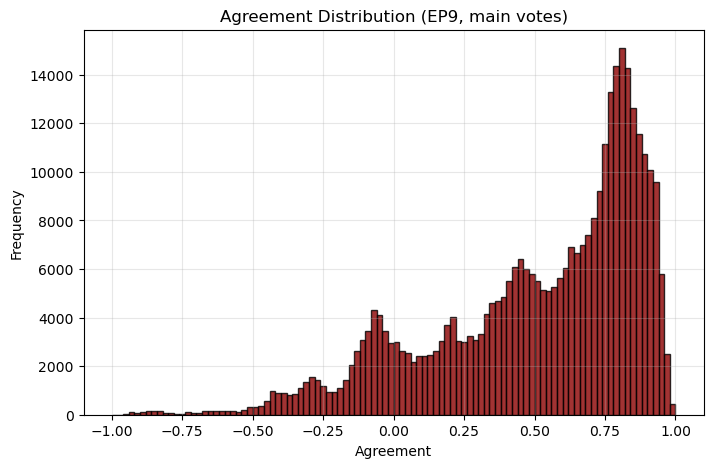

Plotting per-party agreement distributions…


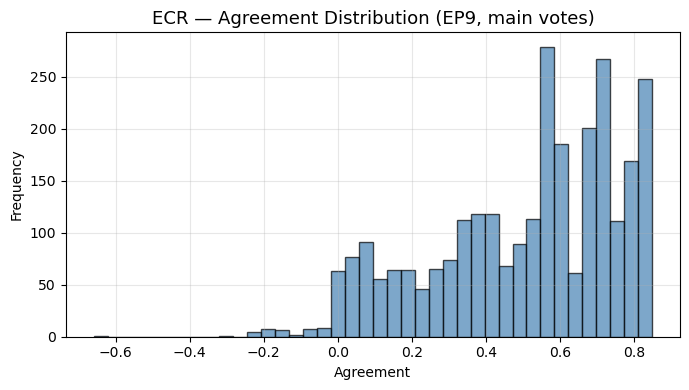

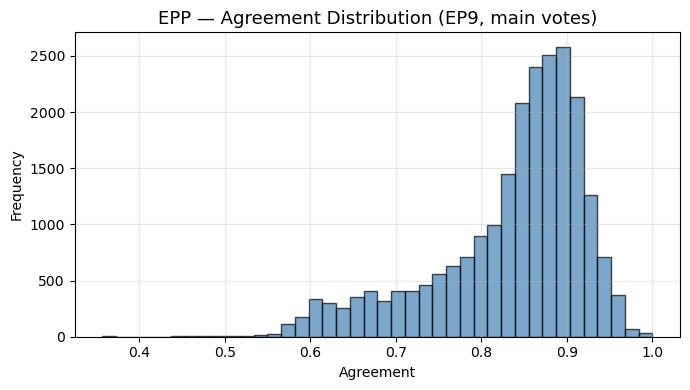

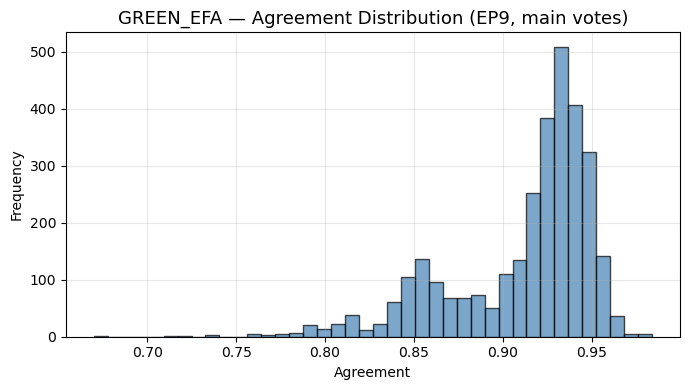

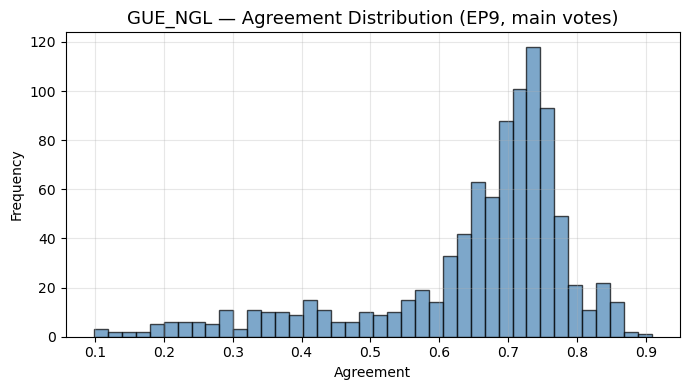

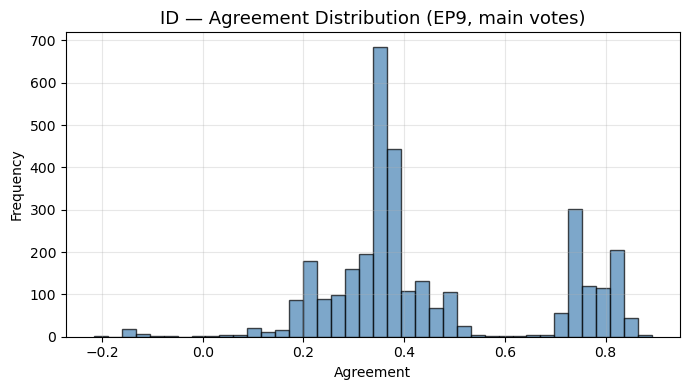

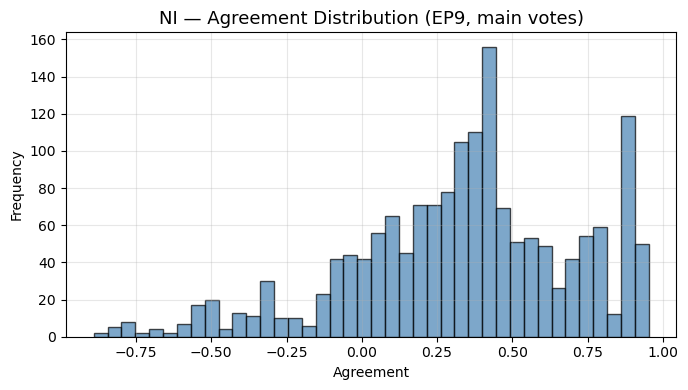

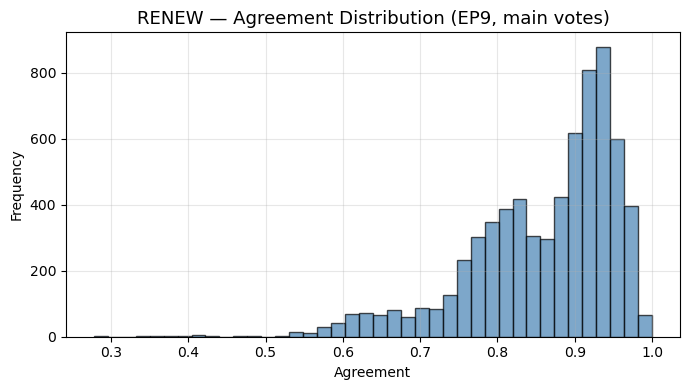

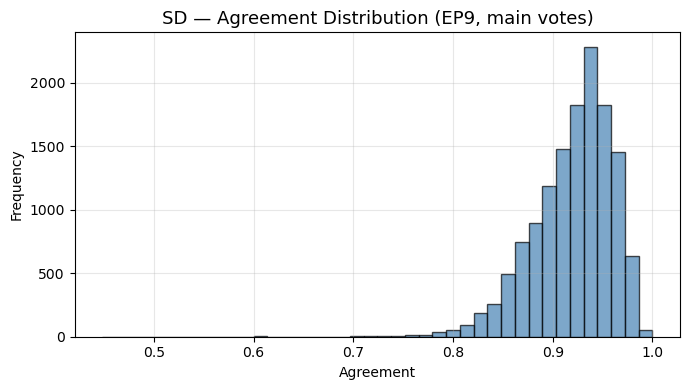


=== EP10 ===
Votes included: 291
Graph: 733 nodes, 268007 edges


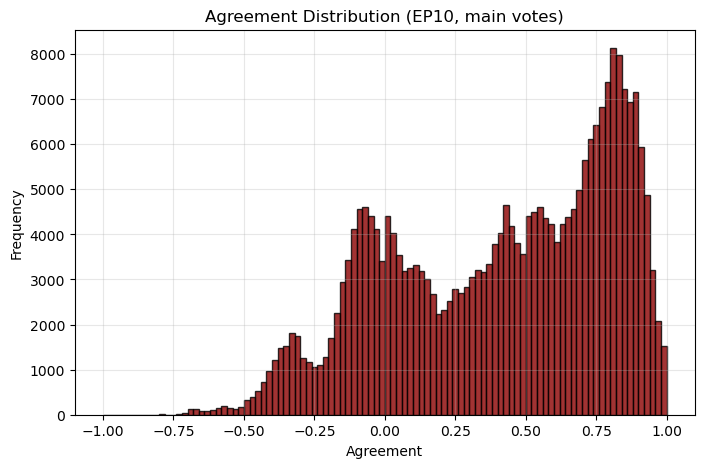

Plotting per-party agreement distributions…


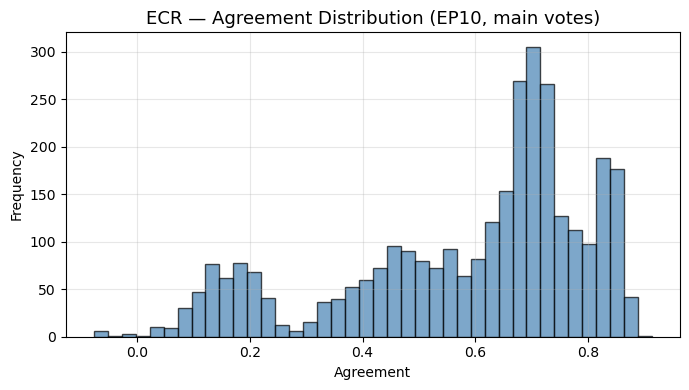

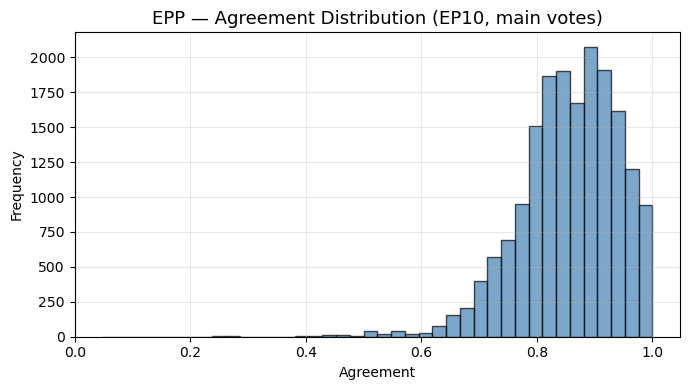

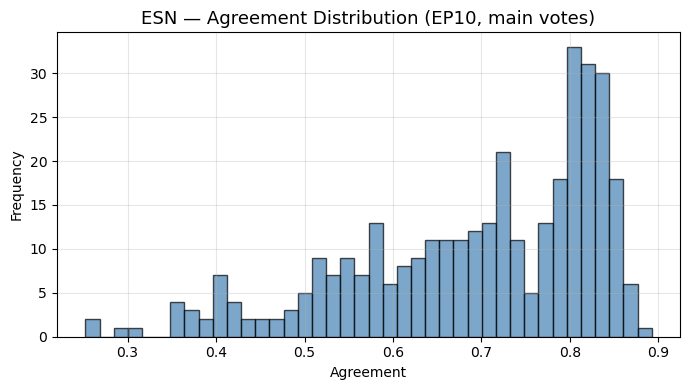

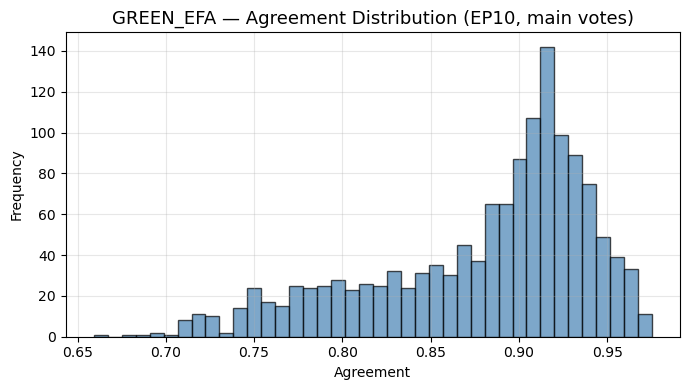

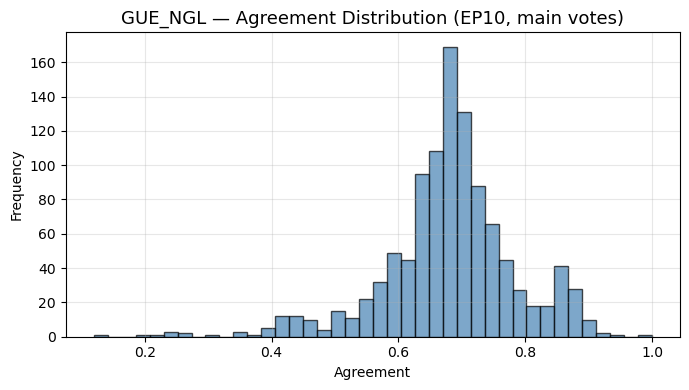

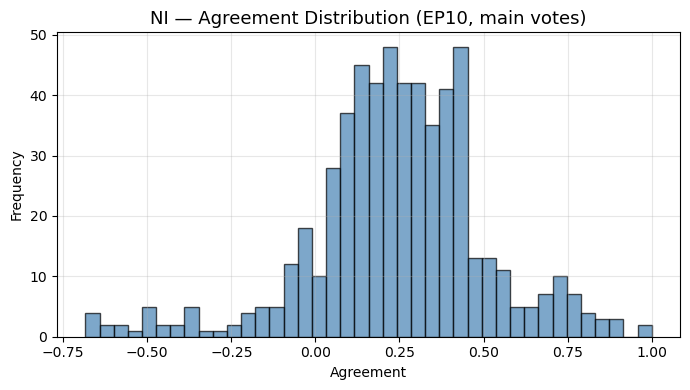

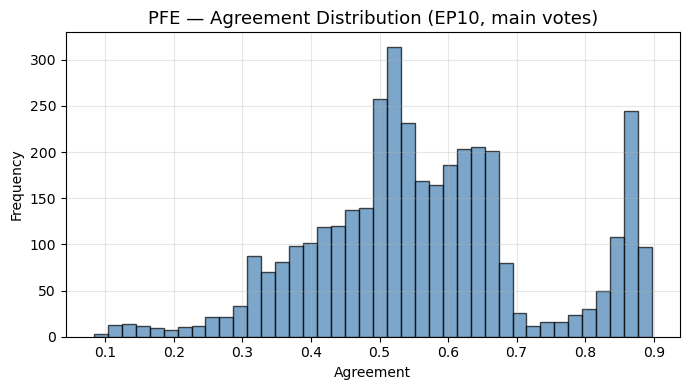

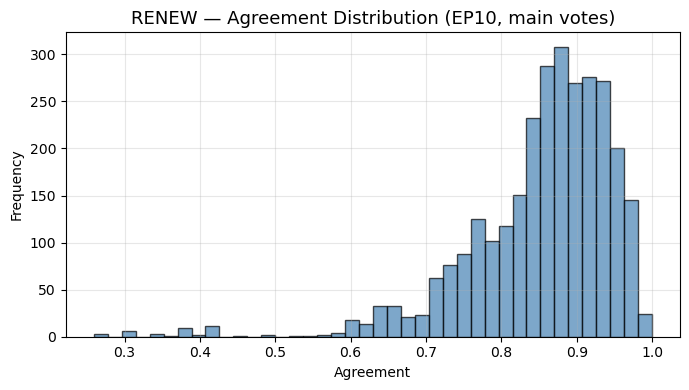

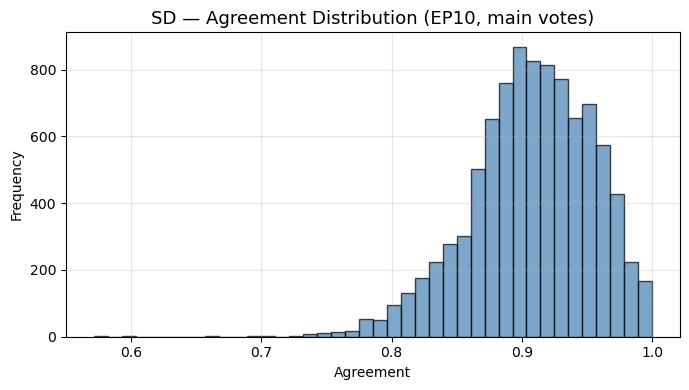


=== Evolution across legislatures ===


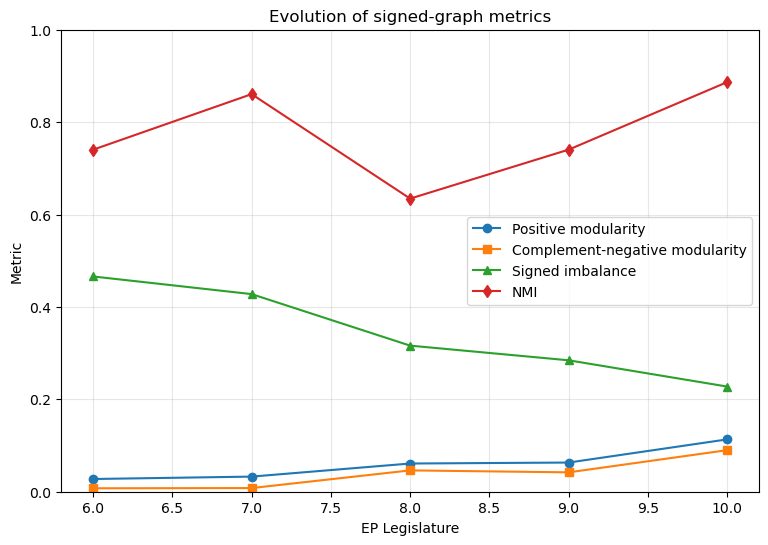

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import community as community_louvain
from sklearn.metrics import normalized_mutual_info_score
import seaborn as sns
import matplotlib.pyplot as plt


# =====================================================================
# STEP 1 — Build Signed Graph (Vectorized)
# =====================================================================

def build_signed_graph_fast(vote_df):
    mapping = {'FOR': 1, 'AGAINST': -1, 'ABSTENTION': 0, 'DID_NOT_VOTE': np.nan}
    votes_num = vote_df.replace(mapping)
    V = votes_num.to_numpy(dtype=float)
    n = V.shape[0]

    # Mask valid votes
    mask = (~np.isnan(V)).astype(float)
    V_masked = np.nan_to_num(V, nan=0.0)

    valid_counts = mask @ mask.T
    dot_products = (V_masked * mask) @ (V_masked * mask).T

    agreement = np.divide(dot_products, valid_counts,
                          out=np.zeros_like(dot_products),
                          where=valid_counts > 0)

    # Remove weak relationships
    min_shared = 5
    agreement[valid_counts < min_shared] = np.nan

    # Build graph
    G = nx.Graph()
    names = vote_df.index.tolist()

    for i in range(n):
        for j in range(i + 1, n):
            w = agreement[i, j]
            if np.isnan(w):
                continue
            G.add_edge(names[i], names[j],
                       weight=abs(w),
                       sign='+' if w >= 0 else '-')

    return G, agreement, names


# =====================================================================
# STEP 2 — Subgraphs
# =====================================================================

def positive_subgraph(G):
    H = nx.Graph()
    H.add_nodes_from(G.nodes())
    for u, v, d in G.edges(data=True):
        if d["sign"] == "+":
            H.add_edge(u, v, weight=d["weight"])
    return H


def complementary_negative_subgraph(G):
    nodes = list(G.nodes)
    neg_edges = {(min(u, v), max(u, v)) for u, v, d in G.edges(data=True)
                 if d["sign"] == "-"}
    H = nx.Graph()
    H.add_nodes_from(nodes)

    for i, u in enumerate(nodes):
        for v in nodes[i + 1:]:
            if (u, v) not in neg_edges:
                H.add_edge(u, v, weight=1.0)
    return H


# =====================================================================
# STEP 3 — Louvain, imbalance
# =====================================================================

def louvain_partition(G):
    if len(G) == 0:
        return {}, 0
    part = community_louvain.best_partition(G, weight='weight')
    Q = community_louvain.modularity(part, G, weight='weight')
    return part, Q


def compute_imbalance(G, part):
    if len(G.edges) == 0:
        return 0

    imb = sum(
        d["weight"]
        for u, v, d in G.edges(data=True)
        if (d["sign"] == "-" and part[u] == part[v]) or
           (d["sign"] == "+" and part[u] != part[v])
    )
    return imb / len(G.edges)


# =====================================================================
# STEP 4 — Full Analysis
# =====================================================================

def analyze_signed_graph(vote_df):
    G, W, meps = build_signed_graph_fast(vote_df)
    print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

    G_pos = positive_subgraph(G)
    G_cneg = complementary_negative_subgraph(G)

    part_pos, mod_pos = louvain_partition(G_pos)
    part_cneg, mod_cneg = louvain_partition(G_cneg)
    part_full, mod_full = louvain_partition(nx.Graph(G))

    imbalance = compute_imbalance(G, part_full)

    nmi = normalized_mutual_info_score(
        [part_pos.get(n, -1) for n in meps],
        [part_full.get(n, -1) for n in meps]
    )

    return G, W, meps, dict(
        mod_pos=mod_pos,
        mod_cneg=mod_cneg,
        imb_signed=imbalance,
        nmi=nmi
    )


# =====================================================================
# STEP 5 — GLOBAL AGREEMENT DISTRIBUTION
# =====================================================================

def plot_agreement_distribution(W, EP_number=100, main=True):
    vals = W[np.triu_indices_from(W, k=1)]
    vals = vals[~np.isnan(vals)]

    title = (f"Agreement Distribution (EP{EP_number}, main votes)"
             if main else f"Agreement Distribution (EP{EP_number}, all votes)")

    plt.figure(figsize=(8, 5))
    plt.hist(vals, bins=100, color="darkred", edgecolor="black", alpha=0.8)
    plt.title(title)
    plt.xlabel("Agreement")
    plt.ylabel("Frequency")
    plt.grid(alpha=0.3)
    plt.show()


# =====================================================================
# STEP 6 — AGREEMENT DISTRIBUTION PER PARTY (NEW!)
# =====================================================================

def plot_agreement_distribution_per_party(W, meps, votes_df, EP_number=100, main=True):

    if "member.group.short_label" not in votes_df.columns:
        print("No party column available.")
        return

    # Align party labels with meps
    party_series = votes_df["member.group.short_label"].astype(str)
    party_series.index = np.arange(len(party_series))
    party_labels = party_series.loc[:len(meps)-1]

    df = pd.DataFrame(W, index=meps, columns=meps)
    df["party"] = party_labels.values

    parties = sorted(df["party"].dropna().unique())

    for party in parties:
        members = df.index[df["party"] == party].tolist()
        if len(members) < 3:
            continue

        # Extract agreement scores
        idx = [df.index.get_loc(m) for m in members]
        W_sub = W[np.ix_(idx, idx)]
        vals = W_sub[np.triu_indices_from(W_sub, k=1)]
        vals = vals[~np.isnan(vals)]

        title = (f"{party} — Agreement Distribution (EP{EP_number}, main votes)"
                 if main else
                 f"{party} — Agreement Distribution (EP{EP_number}, all votes)")

        plt.figure(figsize=(7, 4))
        plt.hist(vals, bins=40, color="steelblue", edgecolor="black", alpha=0.7)
        plt.title(title, fontsize=13)
        plt.xlabel("Agreement")
        plt.ylabel("Frequency")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()


# =====================================================================
# STEP 7 — EVOLUTION PLOT
# =====================================================================

def plot_metrics_evolution(results_dict):
    df = pd.DataFrame(results_dict).T.sort_index()

    plt.figure(figsize=(9, 6))
    plt.plot(df.index, df['mod_pos'], 'o-', label='Positive modularity')
    plt.plot(df.index, df['mod_cneg'], 's-', label='Complement-negative modularity')
    plt.plot(df.index, df['imb_signed'], '^-', label='Signed imbalance')
    plt.plot(df.index, df['nmi'], 'd-', label='NMI')

    plt.xlabel("EP Legislature")
    plt.ylabel("Metric")
    plt.title("Evolution of signed-graph metrics")
    plt.ylim(0, 1)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()


# =====================================================================
# MAIN
# =====================================================================

if __name__ == "__main__":
    main = True
    all_results = {}

    for EP in range(6, 11):

        print(f"\n=== EP{EP} ===")

        # Load main or all votes
        if main:
            votes = pd.read_csv(f"data/all_votes_main_EP{EP}.csv")
        else:
            votes = pd.read_csv(f"data/all_votes_EP{EP}.csv")

        # Keep only vote columns
        vote_cols = [c for c in votes.columns if c.isdigit()]
        votes_core = votes[vote_cols].copy()

        # Remove MEPs with >90% missing
        valid = votes_core.isna().mean(axis=1) < 0.9
        votes_core = votes_core.loc[valid]
        votes = votes.loc[valid]

        votes_core.index = np.arange(len(votes_core))

        print("Votes included:", len(votes_core.columns))

        # Run analysis
        G, W, meps, results = analyze_signed_graph(votes_core)
        all_results[EP] = results

        # Global distribution
        plot_agreement_distribution(W, EP_number=EP, main=main)

        # Per-party distributions
        print("Plotting per-party agreement distributions…")
        plot_agreement_distribution_per_party(W, meps, votes,
                                              EP_number=EP, main=main)

    print("\n=== Evolution across legislatures ===")
    plot_metrics_evolution(all_results)